**K-medoids algorithm for color clustering**
<br>
<br>
In this example, we apply the k-medoids algorithm in order to cluster the image colors, a process that reduces the number of distinct colors used in an image.
<br>
<br>
The image can be downloaded in the following link: https://d3w52z135jkm97.cloudfront.net/uploads/donor/photo/15599/profile_48x48_Pat_Hector.jpg

48 48


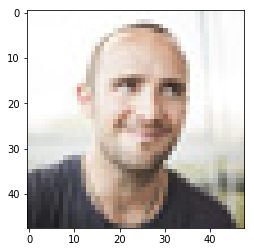

In [140]:
import os
import numpy as np
import math
from pyspark import SparkContext
from pyspark import SparkConf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
sc = SparkContext.getOrCreate()

#Read file
filename = os.path.join("Data","profile2.jpg")
Img=mpimg.imread(filename)
height=len(Img)
width=len(Img[0])
n=3
k=2
print width, height
plt.imshow(Img)
plt.show()


In [141]:
from scipy.spatial import distance
from scipy.spatial.distance import cdist

#Return the distance between two points
def DistPP(point1, point2):
    sumDist=0
    for i in range(0,n):
        pointA=toFloat(point1[i])
        pointB=toFloat(point2[i])
        sumDist=sumDist+((pointA-pointB)**2)
    return np.sqrt(sumDist)

#Return the centroid of a point
def Cluster(point, Centroids):
    mini=0
    for i in range(1,k):
        if DistPP(Centroids[mini], point) > DistPP(Centroids[i], point):
            mini=i
    return mini  

#Return the centroid array of a point
def ClusterArray(point, Centroids):
    mini=0
    for i in range(1,2):
        if DistPP(Centroids[mini], point) > DistPP(Centroids[i], point):
            mini=i
    return Centroids[mini]  

#Convert numeric to float
def toFloat(x):
    try:
        return float(x)
    except(ValueError, TypeError):
        return   0.0

#Convert matrix to list in order to create a RDD
def toRDD(Img):
    listR=[None]*(height*width)
    for i in range(0,height):
        for j in range(0, width):
            listR[width*i+j]= Img[i][j]
    return listR

In [142]:
#Create a RDD considering the image
ImagePre=[list(t) for t in set(tuple(element) for element in toRDD(Img))]
ImageIni=sc.parallelize(ImagePre)

#Initial centroids 
from numpy import inf
Centroids= ImageIni.takeSample(True, k, 1)
Costs=np.empty(k)
Costs.fill(inf)
Finish=False
Iter=0          
print Centroids
print Costs

[[192, 152, 127], [220, 221, 215]]
[ inf  inf]


In [143]:
from  operator import add
while Finish==False or Iter<=10:
    Iter=Iter+1
    #Determine the clusters and current cost
    ImageClusters = (ImageIni
               .map(lambda x:( Cluster(x, Centroids), x))
                )
    ImageDistances = (ImageClusters
               .map(lambda x: (x[0], DistPP(Centroids[x[0]], x[1])))
               )
    Finish=True
    for i in range(0,k):
        #Separate the clusters
        Points=(ImageClusters
          .filter(lambda x: x[0]==i)
          .map(lambda x: x[1])
          .zipWithUniqueId()
          .map(lambda x: (x[1], x[0]))
          )
        #Combine the elements of the clusters to calculate the distances
        Combinations=Points.cartesian(Points)
        #Calculate the distance between each pair of elements of clusters
        Distances=(Combinations
            .map(lambda x: (x[0][0], DistPP(x[0][1],x[1][1])))
          )
        #Determine the cost of each element of the clusters
        SumCosts=(Distances
           .reduceByKey(add)
           )
        #Sort the costs in order to find the minimum costs
        Sorted=sorted(SumCosts.collect(), key=lambda x: x[1])
        #Define the new costs
        NewCost=Sorted[0][1]
        #Check if the algorithm terminates
        if NewCost<Costs[i]:
            Costs[i]=NewCost
            Finish=False
        #Find the id of the new centroids
        idNew=Sorted[0][0]
        newCentroid=(Points
             .filter(lambda x: x[0]==idNew)
        ).collect()[0][1]
        Centroids[i]=newCentroid

In [153]:
#Find the final clusters
ImageClustersFinal =(ImageIni
               .map(lambda x:( ClusterArray(x, Centroids), x))
                ).collect()

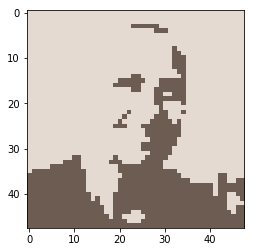

In [155]:
#Print the image output
ImageFinal=Img
ImageFinal.setflags(write=1)
for i in range(0,height):
        for j in range(0, width):
            for k in range(0, ImageIni.count()):
                if ImageFinal[i][j][0]==ImageClustersFinal[k][1][0] and ImageFinal[i][j][1]==ImageClustersFinal[k][1][1] and ImageFinal[i][j][2]==ImageClustersFinal[k][1][2]:
                    ImageFinal[i][j]= ImageClustersFinal[k][0]

plt.imshow(ImageFinal)
plt.show()